<a href="https://colab.research.google.com/github/AdityaChaubeyIITM/ImageClassification/blob/main/DogSpeciesResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import kagglehub
dataset_path = kagglehub.dataset_download('jessicali9530/stanford-dogs-dataset')
print('Data source import complete.')
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, balanced_accuracy_score
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
!pip install torchcam
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

KeyboardInterrupt: 

In [11]:
!pip uninstall opencv-python opencv-python-headless -y
!pip install opencv-python-headless==4.5.5.64
!pip install albumentations==1.3.0

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64
  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached opencv_python_headless-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (47.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.5.5.64 which is incompatible.


In [ ]:
import numpy as np
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, balanced_accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import kagglehub

In [ ]:
import torchvision
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, balanced_accuracy_score
#from albumentations.pytorch import ToTensorV2
#import albumentations as A
import cv2
from PIL import Image

# ==== Step 1: Data Setup ====
import kagglehub
dataset_path = kagglehub.dataset_download('jessicali9530/stanford-dogs-dataset')
"""
# Custom dataset to integrate Albumentations
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)['image']

        return img, label
"""
# ==== Step 2: Albumentations Transform ====
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

# ==== Step 3: Model Definition ====
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        _, preds = torch.max(out, dim=1)
        return {
            'val_loss': loss.detach(),
            'preds': preds.cpu(),
            'labels': labels.cpu()
        }

    def validation_epoch_end(self, outputs):
        val_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(val_losses).mean().item()

        all_preds = torch.cat([x['preds'] for x in outputs])
        all_labels = torch.cat([x['labels'] for x in outputs])

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        kappa = cohen_kappa_score(all_labels, all_preds)
        bal_acc = balanced_accuracy_score(all_labels, all_preds)

        return {
            'val_loss': epoch_loss,
            'val_acc': acc,
            'val_f1': f1,
            'val_kappa': kappa,
            'val_bal_acc': bal_acc
        }

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], "
              f"Train Loss: {result['train_loss']:.4f}, "
              f"Val Loss: {result['val_loss']:.4f}, "
              f"Acc: {result['val_acc']:.4f}, "
              f"F1: {result['val_f1']:.4f}, "
              f"Kappa: {result['val_kappa']:.4f}, "
              f"Balanced Acc: {result['val_bal_acc']:.4f}")

class ResNetClassifier(ImageClassificationBase):
    def __init__(self, num_classes=120):
        super().__init__()
        self.network = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

# ==== Step 4: Helper Functions ====
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history



# ==== Step 5: Load Dataset & Prepare Stratified K-Fold ====
raw_dataset = ImageFolder(dataset_path + '/images/Images')
labels = [sample[1] for sample in raw_dataset.samples]
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
device = get_default_device()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 6.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model = ResNetClassifier(num_classes=120)
model_path = "/content/drive/MyDrive/resnet_dog_classifier.pth"

# Solution 2: Or use this more flexible approach
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Important: set to eval mode


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ResNetClassifier(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f'\n--- Fold {fold + 1} ---')

    train_subset = Subset(raw_dataset, train_idx)
    val_subset = Subset(raw_dataset, val_idx)

    # Create augmented datasets
    train_ds = AlbumentationsDataset(train_subset, transform=get_transforms(train=True))
    val_ds = AlbumentationsDataset(val_subset, transform=get_transforms(train=False))

    # Class balancing
    class_counts = np.bincount([raw_dataset[i][1] for i in train_idx])
    class_weights = 1. / class_counts
    sample_weights = [class_weights[raw_dataset[i][1]] for i in train_idx]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    train_dl = DataLoader(train_ds, batch_size=64, sampler=sampler, num_workers=2, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)

    model = to_device(ResNetClassifier(num_classes=len(raw_dataset.classes)), device)

    history = fit(epochs=10, lr=0.001, model=model, train_loader=train_dl, val_loader=val_dl)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44283 sha256=f59f7e3266255908c71b836892c760f4364c76c8e7d8d59bcfe427df7f2fdaf3
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam
✅ Predicted Label: n02085782-Japanese_spaniel
🎯 Actual Label: n02085782-Japanese_spaniel


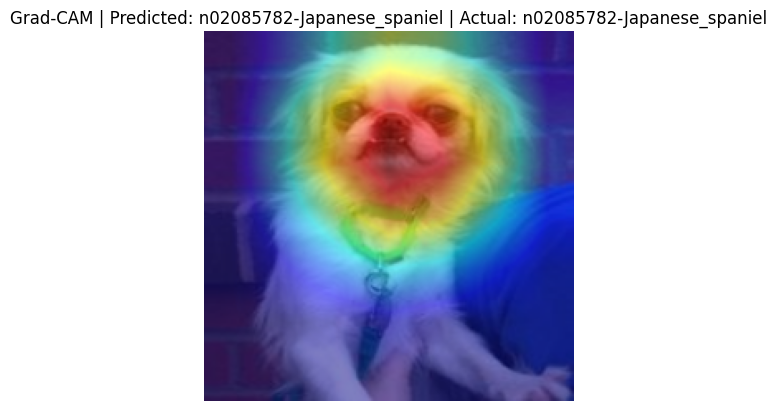

In [ ]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import cv2

# ---- Step 1: Get first image from the raw dataset ----
first_img, actual_label = raw_dataset[202]
img_np = np.array(first_img)

# ---- Step 2: Preprocess for model ----
val_transform = get_transforms(train=False)
input_tensor = val_transform(image=img_np)['image'].unsqueeze(0).to(device)

# ---- Step 3: Set up Grad-CAM ----
target_layer = model.network.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

# ---- Step 4: Predict ----
model.eval()
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
targets = [ClassifierOutputTarget(pred_class)]

# ---- Step 5: Get CAM ----
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# ---- Step 6: Resize original image to match CAM ----
resized_img = cv2.resize(img_np, (224, 224))  # Resize to match CAM shape
rgb_img = resized_img.astype(np.float32) / 255.0  # Normalize to [0, 1]

# ---- Step 7: Overlay CAM ----
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# ---- Step 8: Display and Label Output ----
predicted_label_name = raw_dataset.classes[pred_class]
actual_label_name = raw_dataset.classes[actual_label]

print(f"✅ Predicted Label: {predicted_label_name}")
print(f"🎯 Actual Label: {actual_label_name}")

plt.imshow(cam_image)
plt.title(f"Grad-CAM | Predicted: {predicted_label_name} | Actual: {actual_label_name}")
plt.axis('off')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

✅ Predicted Label: n02085782-Japanese_spaniel
🎯 Actual Label: n02085782-Japanese_spaniel


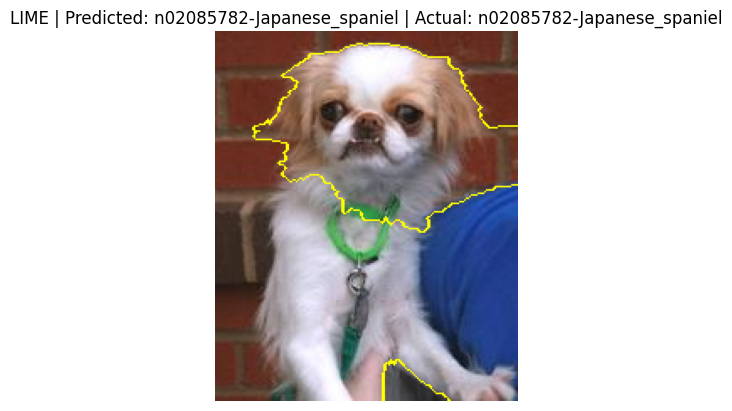

In [ ]:
# ---- Step 1: Get image and label ----
first_img, actual_label = raw_dataset[202]
img_np = np.array(first_img)

# ---- Step 2: Define model prediction function for LIME ----
def batch_predict(images):
    model.eval()
    batch = torch.stack([
        val_transform(image=img)['image'] for img in images
    ], dim=0).to(device)
    logits = model(batch)
    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    return probs

# ---- Step 3: Run LIME explainer ----
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img_np,
    classifier_fn=batch_predict,
    top_labels=1,
    hide_color=0,
    num_samples=100  # More samples = better quality, slower
)

# ---- Step 4: Get visualization for predicted class ----
pred_class = batch_predict([img_np]).argmax()
lime_image_np, mask = explanation.get_image_and_mask(
    label=pred_class,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# ---- Step 5: Plot and compare ----
predicted_label_name = raw_dataset.classes[pred_class]
actual_label_name = raw_dataset.classes[actual_label]

print(f"✅ Predicted Label: {predicted_label_name}")
print(f"🎯 Actual Label: {actual_label_name}")

plt.imshow(mark_boundaries(lime_image_np, mask))
plt.title(f"LIME | Predicted: {predicted_label_name} | Actual: {actual_label_name}")
plt.axis('off')
plt.show()